In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc

import os

%load_ext autoreload
%autoreload 2

# run for all cells (OFF LINE)

run 
```
python3 stcl_batch.py [DATASET] --dim D
```

datasets
* 20180618
* 20180621
* 20180626
* 20180828

## load stim and spike data

In [2]:
folder_name = "data"

#dataset_name = "20180618"
#dataset_name = "20180621"
dataset_name = "20180626"
# dataset_name = "20180828"

stim, spike_train, info = pysta.load_data(dataset_name, folder_name)

# channel_names = [ch.replace("ch_","") for ch in info["channel_names"]]   # NOT NEEDED ANYMORE
# info["channel_names"]
# info["cell_types"]


['dataset_name', 'stim', 'spike_train', 'info']
(64, 9000)
(156, 9000)
{'channel_names': ['12a', '12b', '12c', '13a', '13b', '13c', '13d', '13e', '14a', '14b', '14c', '14d', '16a', '16b', '16c', '17a', '17b', '17c', '17d', '21a', '21b', '21c', '21d', '21e', '22a', '22b', '23a', '23b', '23c', '23d', '25a', '25b', '25c', '26a', '26b', '26c', '26d', '27a', '27b', '27c', '27d', '28a', '28b', '28c', '31a', '31b', '31c', '31d', '32a', '32b', '32c', '33a', '33b', '33c', '33d', '35a', '35b', '35c', '35d', '35e', '35f', '35g', '36a', '36b', '36c', '36d', '37a', '37b', '37c', '37d', '37e', '38a', '41a', '41b', '41c', '41d', '42a', '42b', '42c', '43a', '43b', '43c', '45a', '45b', '45c', '46a', '46b', '47a', '48a', '48b', '48c', '48d', '48e', '51a', '51b', '53a', '53b', '53c', '53d', '54a', '54b', '54c', '54d', '56a', '56b', '58a', '61a', '61b', '62a', '62b', '63a', '63b', '63c', '63d', '63e', '64a', '65a', '65b', '65c', '68a', '68b', '71a', '71b', '71c', '72a', '72b', '72c', '72d', '72e', '73a', 

In [3]:
# calc number of spikes
tap = 8 # -700 ms ~ 0

num_samples = list()
for idx in range(spike_train.shape[0]):    
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
    num_samples.append(spike_triggered_stim.shape[0])

num_samples_df = pd.DataFrame({"channel_name": info["channel_names"], "number_of_samples": num_samples})
# num_samples_df

## read largest eigenvalues from STC results

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4532e4a7b8>,
      dtype=object)

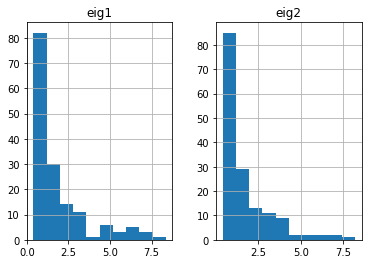

In [40]:
folder_name = "{}_tap{}_stc_classic".format(dataset_name, tap)

largest_eigen_values = list()
second_largest_eigen_values = list()
for channel_name in info["channel_names"]:
    filename = "ch_{}_eig_val.txt".format(channel_name)
    #print(os.path.join(folder_name,filename))    
    eigs = np.loadtxt(os.path.join(folder_name,filename))
    largest_eigen_values.append(eigs[0])
    second_largest_eigen_values.append(eigs[1])
largest_eigen_values_df = pd.DataFrame({"channel_name": info["channel_names"], "eig1": largest_eigen_values, "eig2": second_largest_eigen_values})

largest_eigen_values_df.hist()

## read clustering results (dim=1)

In [41]:
dim = 1
folder_name = "{}_tap{}_stc_classic_cluster_dim{}".format(dataset_name, tap, dim)
filename = os.path.join(folder_name, "clusters.csv")

clusters = pd.read_csv(filename)
# weights
# weights.head()

clusters["max_weight"] = np.maximum(clusters["weight1"], clusters["weight2"])

# combine number of samples
clusters = clusters.merge(num_samples_df, on="channel_name") #, how="outer")

# combine largest eigen values
clusters = clusters.merge(largest_eigen_values_df, on="channel_name", how="outer")


filename = os.path.join(folder_name, "clusters_combined.csv")
clusters.to_csv(filename, index=None)

In [42]:
clusters_with_negative_inner_product = clusters.loc[clusters["inner_product"]<0,:]

print(len(clusters_with_negative_inner_product), len(clusters))
clusters_with_negative_inner_product

120 156


,channel_name,weight1,weight2,inner_product,max_weight,number_of_samples,eig1,eig2
0,12a,0.515690,0.484310,-0.128925,0.515690,2868,0.578403,0.552195
1,12b,0.461264,0.538736,-0.108067,0.538736,1123,0.744122,0.728674
3,13a,0.491225,0.508775,-0.207087,0.508775,6610,0.432604,0.424380
6,13d,0.503472,0.496528,-0.346277,0.503472,288,1.776912,1.658930
7,13e,0.508929,0.491071,-0.257097,0.508929,112,2.438375,2.330179
...,...,...,...,...,...,...,...,...
150,86b,0.463213,0.536787,-0.325101,0.536787,1332,0.788005,0.759195
151,86c,0.498099,0.501901,-0.268531,0.501901,526,1.188350,1.152660
152,86d,0.496644,0.503356,-0.054230,0.503356,149,2.244849,2.097623
154,87b,0.497437,0.502563,-0.117087,0.502563,3512,0.487358,0.482080


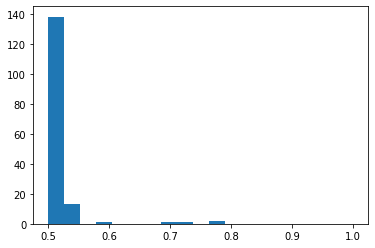

In [43]:
bins = np.linspace(0.5, 1, 20)
plt.hist(clusters["max_weight"], bins=bins)
#clusters["max_weight"].hist()
#plt.
plt.savefig("{}/max_weight_hist.png".format(folder_name))

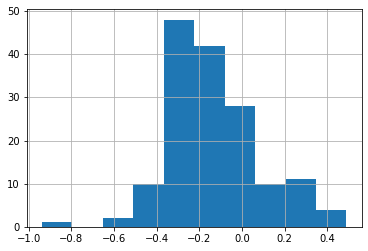

In [44]:
clusters["inner_product"].hist()
plt.savefig("{}/inner_product_hist.png".format(folder_name))

## Combine with cell type info

In [45]:
cell_type = pd.DataFrame({"channel_name": info["channel_names"],
                          "cell_type":   info["cell_types"]})
cell_type

clusters = clusters.merge(cell_type, on="channel_name", how="outer")

In [46]:
filename = os.path.join(folder_name, "clusters_combined.csv")
clusters.to_csv(filename, index=None)

## repeat for each cell type

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4532c54d68>,
      dtype=object)

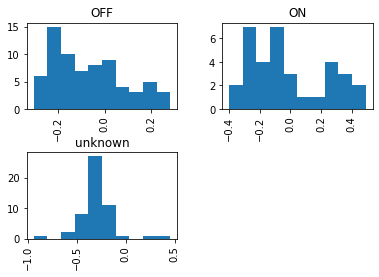

In [47]:
# clusters
#info["cell_types"]
#clusters.groupby("cell_type").hist()
clusters["inner_product"].hist(by=clusters["cell_type"])

In [73]:
# helper function to plot histograms of a column by cell_type
def plot_histogram_by_cell_type(clusters, col_name):
    idx_on = clusters["cell_type"] == "ON"
    clusters.loc[idx_on, col_name].hist(alpha=0.6)

    idx_on = clusters["cell_type"] == "OFF"
    clusters.loc[idx_on, col_name].hist(alpha=0.6)

    idx_unknown = clusters["cell_type"] == "unknown"
    clusters.loc[idx_unknown, col_name].hist(alpha=0.6)

    plt.xlabel(col_name)
    plt.ylabel("count")
    plt.legend(["ON", "OFF", "unknown"])

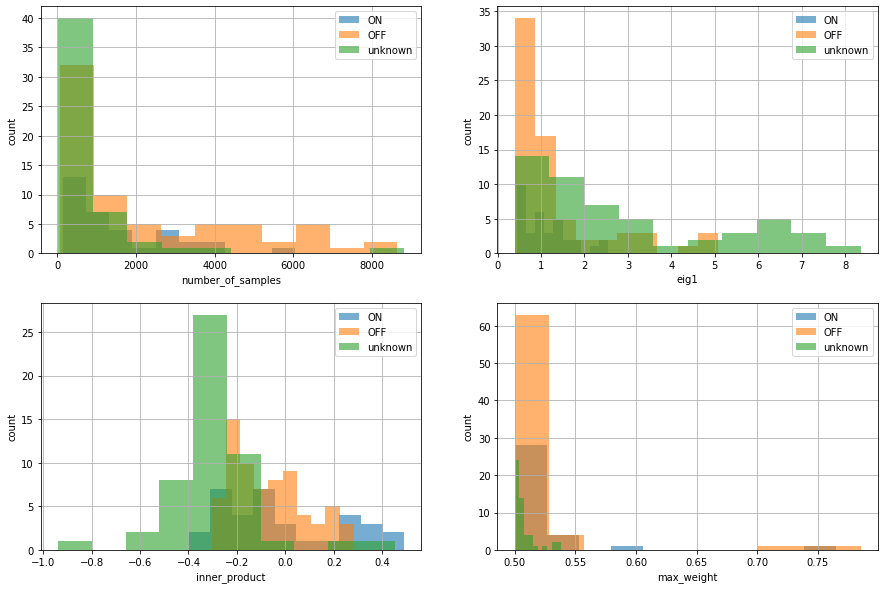

In [82]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plot_histogram_by_cell_type(clusters, "number_of_samples")
plt.subplot(222)
plot_histogram_by_cell_type(clusters, "eig1")
plt.subplot(223)
plot_histogram_by_cell_type(clusters, "inner_product")
plt.subplot(224)
plot_histogram_by_cell_type(clusters, "max_weight")

plt.savefig("{}_tap{}_cluster_dim{}.pdf".format(dataset_name, tap, dim))
plt.savefig("{}_tap{}_cluster_dim{}.png".format(dataset_name, tap, dim))

## Focus on data with enough samples

41
OFF        27
ON         10
unknown     4
Name: cell_type, dtype: int64


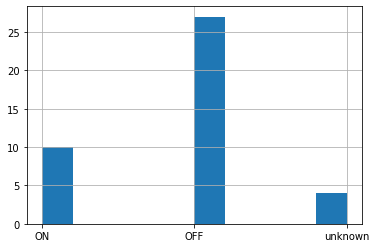

In [67]:
idx_enough_samples = clusters["number_of_samples"]>512*4
#idx_enough_samples = clusters["number_of_samples"]>512 # eigen values are too large
clusters_with_enough_samples = clusters.loc[idx_enough_samples]

print(len(clusters_with_enough_samples))

print(clusters_with_enough_samples["cell_type"].value_counts())

clusters_with_enough_samples["cell_type"].hist()

In [68]:
idx_unknown = clusters_with_enough_samples["cell_type"]=="unknown"
clusters_with_enough_samples.loc[idx_unknown]

,channel_name,weight1,weight2,inner_product,max_weight,number_of_samples,eig1,eig2,cell_type
64,36c,0.524176,0.475824,-0.560819,0.524176,2337,0.798256,0.620102,unknown
76,42a,0.501003,0.498997,-0.226843,0.501003,8822,0.396756,0.395866,unknown
104,56b,0.513731,0.486269,-0.263788,0.513731,2731,0.521560,0.518974,unknown
108,62a,0.505115,0.494885,-0.236699,0.505115,3910,0.491259,0.482335,unknown


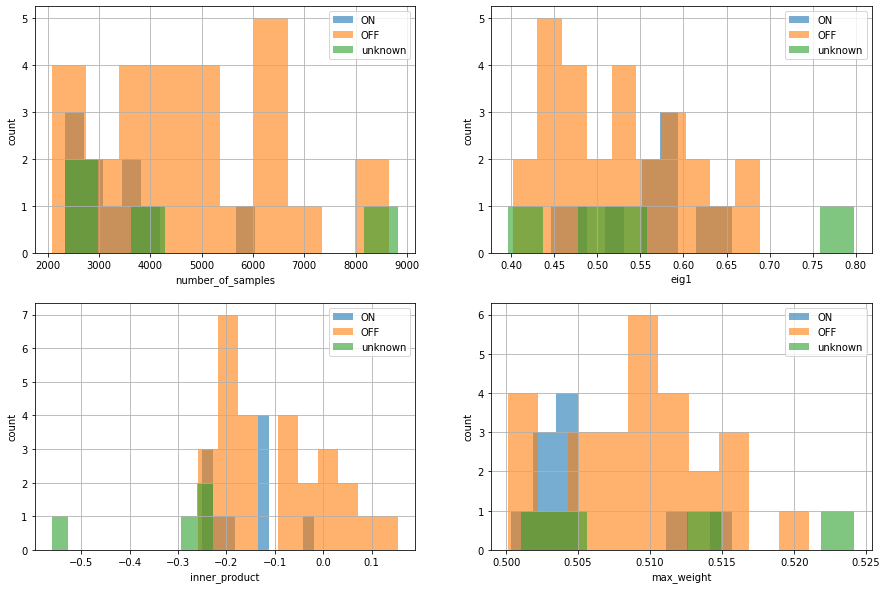

In [83]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plot_histogram_by_cell_type(clusters_with_enough_samples, "number_of_samples")
plt.subplot(222)
plot_histogram_by_cell_type(clusters_with_enough_samples, "eig1")
plt.subplot(223)
plot_histogram_by_cell_type(clusters_with_enough_samples, "inner_product")
plt.subplot(224)
plot_histogram_by_cell_type(clusters_with_enough_samples, "max_weight")

plt.savefig("{}_tap{}_cluster_with_enough_samples_dim{}.pdf".format(dataset_name, tap, dim))
plt.savefig("{}_tap{}_cluster_with_enough_samples_dim{}.png".format(dataset_name, tap, dim))

## paired t-test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

In [ ]:
# from scipy import stats

In [ ]:
# stats.ttest_rel(clusters_dim2["max_weight"], clusters_dim2["max_weight"])

In [ ]:
# stats.ttest_rel(clusters_dim2["inner_product"], clusters_dim2["inner_product"])